In [17]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import List
from utils import dump_dref

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
sns.set_palette("colorblind")


volatile_cores = Path("allocator/latest-dram-c")
peristent_cores = Path("allocator/latest-nvram-c")
legacy_volatile_cores = Path("allocator/230227-143046-dram-legacy-c")
legacy_peristent_cores = Path("allocator/230227-143940-nvram-legacy-c")


def read_orders(dir: str, orders: List[int]) -> pd.DataFrame:
    data = []
    for o in orders:
        d = pd.read_csv(f"{dir}/out_{o}.csv")
        d["order"] = o
        data.append(d)
    data = pd.concat(data)
    data["Allocator"] = data["alloc"]
    data["cores"] = data["x"]
    data["alloc"] = data["get_avg"]
    data["free"] = data["put_avg"]
    return data[["Allocator", "order", "cores", "iteration", "alloc", "free"]]


def read_all_bench(dir: Path, orders: List[int], bulk=True, repeat=True, rand=True) -> pd.DataFrame:
    data = []
    if bulk:
        data_b = read_orders(dir / "bulk", orders)
        data_b["bench"] = "Bulk"
        data.append(data_b)
    if repeat:
        data_r = read_orders(dir / "repeat", orders)
        data_r["bench"] = "Repeat"
        data_r["free+alloc"] = data_r["alloc"]
        del data_r["alloc"]
        del data_r["free"]
        data.append(data_r)
    if rand:
        data_a = read_orders(dir / "rand", orders)
        data_a["bench"] = "Rand"
        del data_a["alloc"]
        data.append(data_a)
    return pd.concat(data)


def save_dref(name: str, groupby: List[str], data: pd.DataFrame):
    out = {}
    data = data.dropna(axis=0).groupby(groupby).mean(numeric_only=True)
    for index, row in data.iterrows():
        out["/".join(map(str, row.name))] = row.values[0]
    with Path(f"out/{name}.dref").open("w+") as f:
        dump_dref(f, name, out)


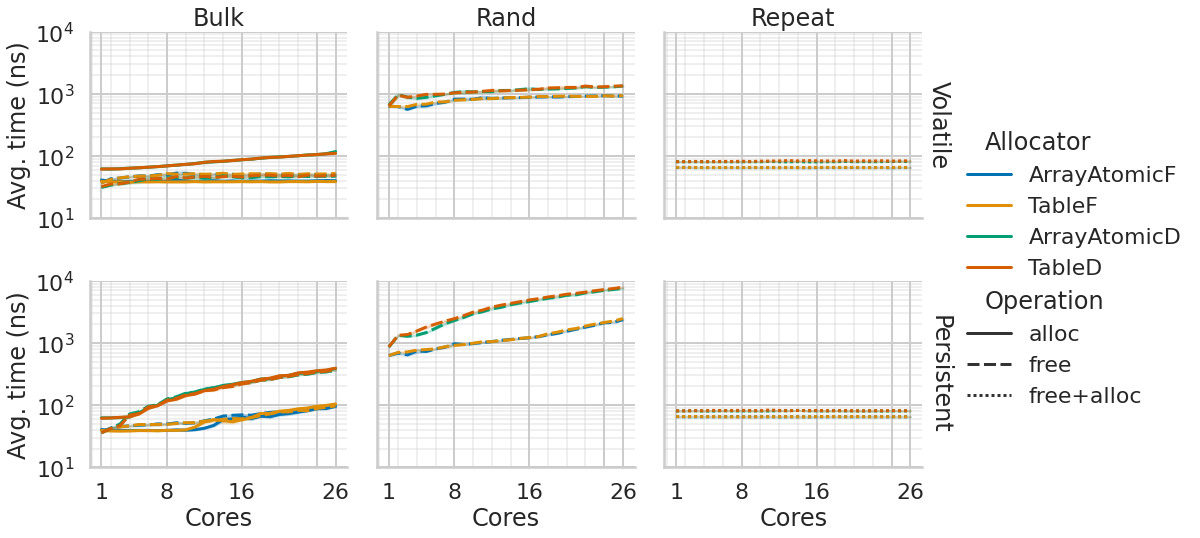

In [21]:
data_l_v = read_all_bench(legacy_volatile_cores, [0])
data_l_v["Memory"] = "Volatile"
data_l_p = read_all_bench(legacy_peristent_cores, [0])
data_l_p["Memory"] = "Persistent"

data = pd.concat([data_l_v, data_l_p])
pgd = data[["Allocator", "bench", "cores", "Memory", "alloc", "free", "free+alloc"]].melt(
    id_vars=["Allocator", "bench", "cores", "Memory"],
    value_vars=["alloc", "free", "free+alloc"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, row="Memory", col="bench", col_order=["Bulk", "Rand", "Repeat"],
                      height=4, aspect=1.2, margin_titles=True)
    g.map_dataframe(sns.lineplot, x="cores", y="time",
                    style="Operation", hue="Allocator")
    g.add_legend(adjust_subtitles=True)

    g.set(xticks=[1, 8, 16, 24, 26])
    for ax in g.axes_dict.values():
        ax.set_xticks(list(range(0, 27, 2)), minor=True)
        ax.grid(which="minor", alpha=0.3)
    g.set(xticklabels=[1, 8, 16, "", 26])

    # g.set(ylim=(0, None))
    g.set(ylim=(10, 10000))
    g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.savefig("out/legacy.pdf")


save_dref("legacy", ["Memory", "Allocator",
          "bench", "cores", "Operation"], pgd)


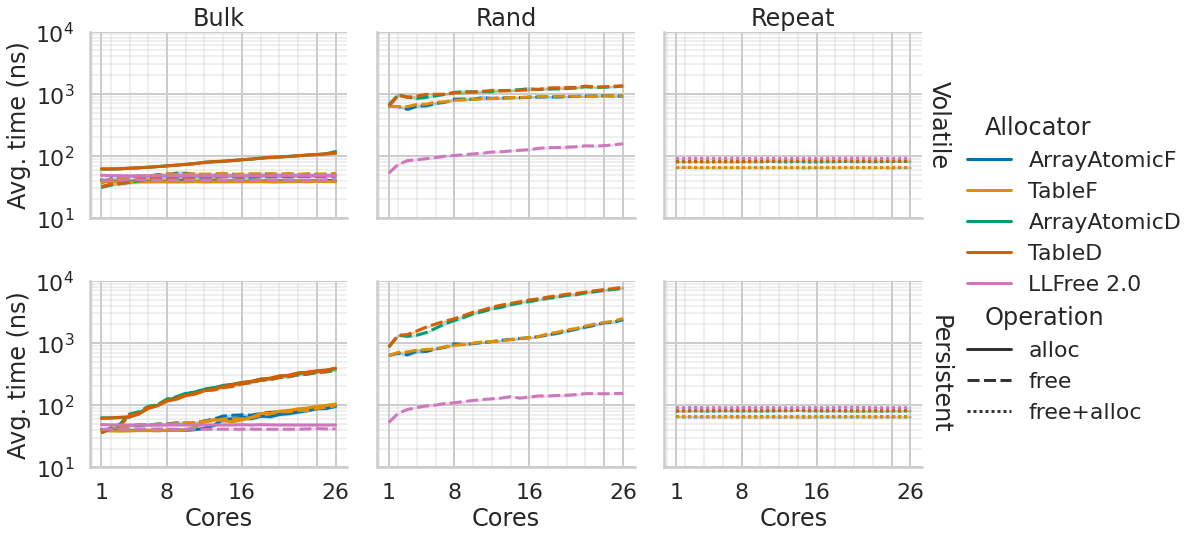

In [20]:
data_l_v = read_all_bench(legacy_volatile_cores, [0])
data_l_v["Memory"] = "Volatile"
data_l_p = read_all_bench(legacy_peristent_cores, [0])
data_l_p["Memory"] = "Persistent"

data_v = read_all_bench(volatile_cores, [0])
data_v["Memory"] = "Volatile"
data_v["Allocator"] = "LLFree 2.0"
data_p = read_all_bench(peristent_cores, [0])
data_p["Memory"] = "Persistent"
data_p["Allocator"] = "LLFree 2.0"

data = pd.concat([data_l_v, data_l_p, data_v, data_p])
pgd = data[["Allocator", "bench", "cores", "Memory", "alloc", "free", "free+alloc"]].melt(
    id_vars=["Allocator", "bench", "cores", "Memory"],
    value_vars=["alloc", "free", "free+alloc"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, row="Memory", col="bench", col_order=["Bulk", "Rand", "Repeat"],
                      height=4, aspect=1.2, margin_titles=True)
    g.map_dataframe(sns.lineplot, x="cores", y="time",
                    style="Operation", hue="Allocator")
    g.add_legend(adjust_subtitles=True)

    g.set(xticks=[1, 8, 16, 24, 26])
    for ax in g.axes_dict.values():
        ax.set_xticks(list(range(0, 27, 2)), minor=True)
        ax.grid(which="minor", alpha=0.3)
    g.set(xticklabels=[1, 8, 16, "", 26])

    # g.set(ylim=(0, None))
    g.set(ylim=(10, 10000))
    g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.savefig("out/legacy2.pdf")
